# Importation des modules

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nwara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Importation 

In [25]:
images_directory = 'Images'
captions_path = 'captions.txt'

# Importer des données à partir d’captions.txt 
with open(captions_path , 'r') as f:
  #  Importez chaque ligne en tant qu’élément de notre liste de lignes
  lines = f.readlines()
  # en minuscules les données , en supprimant la première ligne car elle ne contient que le nom de la colonne
  lines = [line.lower() for line in lines[1:]]

# visualisation
lines[:3]

['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a girl going into a wooden building .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .\n']

# Le prétraitement des Légendes


In [3]:
processed_captions = []

for line in lines:
  caption = line.split(',')[1]
  # Removing all special characters (punctuation, symbols, etc..)
  caption = re.sub(r'[^\w\s]', '', caption)
  # Removing all sequences consisting of one or more digits from the string.
  caption = re.sub(r'\d+', '', caption)
  # Removing extra whitespace
  caption = re.sub(r'\s+', ' ', caption).strip()

  processed_captions.append(caption)


print("les légendes prétraitées :")
print(processed_captions[:3])

les légendes prétraitées :
['a child in a pink dress is climbing up a set of stairs in an entry way', 'a girl going into a wooden building', 'a little girl climbing into a wooden playhouse']


In [4]:
new_lines = []
for i in range(len(processed_captions)):
  # adding the 'start' to the caption as an input and 'end' to mark the end of the caption for the LSTM model
  new_line = lines[i].split(',')[0] + '\t' + 'start '+ processed_captions[i] + ' end\n'
  new_lines.append(new_line)

print("id des images avec leurs légendes ( en ajoutant start et end ): ")
print(new_lines[:3])

id des images avec leurs légendes ( en ajoutant start et end ): 
['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n', '1000268201_693b08cb0e.jpg\tstart a girl going into a wooden building end\n', '1000268201_693b08cb0e.jpg\tstart a little girl climbing into a wooden playhouse end\n']


# Visualisation des données

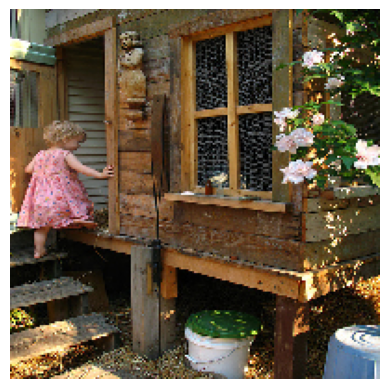

Caption: a child in a pink dress is climbing up a set of stairs in an entry way .
Caption: a girl going into a wooden building .
Caption: a little girl climbing into a wooden playhouse .
Caption: a little girl climbing the stairs to her playhouse .
Caption: a little girl in a pink dress going into a wooden cabin .


In [5]:
captions =[]
for line in lines[:5:1]:
    # Split the line to get the file name and the caption
    filename = line.split(',')[0]
    captions.append(line.split(',')[1].strip())

image_load = load_img(images_directory + '/' + filename.strip(), target_size=(199, 199))
# Display the image
plt.imshow(image_load)
# Disable the axes
plt.axis('off')
plt.show()
for caption in captions:
        print("Caption:", caption)

# Création du vocabulaire

In [6]:
unique_words = set()
for sentence in processed_captions:
    words = word_tokenize(sentence)
    unique_words.update(words)

vocab_size = len(unique_words)
print('the size of the vocabulary is : ', vocab_size)

the size of the vocabulary is :  8584


# Fractionnement des données

In [7]:
ids = os.listdir(images_directory)

# Fractionnement des données
train_ids , test_ids = train_test_split(ids , test_size = 0.15 , random_state =42)
val_ids , test_ids = train_test_split(test_ids , test_size = 0.1 , random_state =42)

#
train_id_and_captions, val_id_and_captions, test_id_and_captions = [], [], []
for line in new_lines:
    image_id, _ = line.split('\t')

    if image_id in train_ids:
        train_id_and_captions.append(line)

    elif image_id in val_ids:
        val_id_and_captions.append(line)

    elif image_id in test_ids:
        test_id_and_captions.append(line)

    else:
        print('Image ID not found!')



print('le nombre des images dans les données d entrainement : ', len(train_id_and_captions)/ 5)
print('le nombre des images dans les données de test : ', len(test_id_and_captions)/ 5)
print('le nombre des images dans les données de validation : ', len(val_id_and_captions)/5)

le nombre des images dans les données d entrainement :  6877.0
le nombre des images dans les données de test :  122.0
le nombre des images dans les données de validation :  1092.0


# Chargement du modèle pré-entraîné (InceptionV3)

In [8]:
inceptionV3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inceptionV3_model = Model(inputs=inceptionV3_model.inputs, outputs=inceptionV3_model.layers[-2].output)
inceptionV3_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

# Préparation des données pour le modèle CNN

In [9]:
def image_processing_for_model(image_path):
    image = load_img(image_path, target_size=(299, 299))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image

def image_features_extraction(cnn_model, image_path):
    image = image_processing_for_model(image_path)
    img_features = cnn_model.predict(image, verbose=0)
    return img_features

train_image_features, val_image_features, test_image_features = {}, {}, {} 

for image_id in ids:
    image_path = os.path.join(images_directory, image_id)
    image_features = image_features_extraction(inceptionV3_model, image_path)

    if image_id in train_ids:
        train_image_features[image_id] = image_features.flatten()

    elif image_id in val_ids:
        val_image_features[image_id] = image_features.flatten()

    elif image_id in test_ids:
        test_image_features[image_id]= image_features.flatten()

    else:
        print('Image ID not found!')

# Définition de la taille de lot pour l'entrainement et pour le test, longeur maximale de la légendes et la dimension de sortie du modèle inceptionV3

In [10]:
tokenizer_instance = Tokenizer()
tokenizer_instance.fit_on_texts(processed_captions)

# Définition de la longueur maximale des sous-titres
caption_max_length = max(len(caption.split()) for caption in processed_captions) + 1

# Définition de la taille du lot
batch_size_train = 270
batch_size_val = 150

# Définition de la dimension de sortie CNN (taille du vecteur de caractéristique d’InceptionV3)
output_dim_of_cnn_model = inceptionV3_model.output_shape[1]

print("La longueur maximale des sous-titres est : " , caption_max_length)
print("la dimension de sortie du modèle inceptionV3 est : " , output_dim_of_cnn_model)

La longueur maximale des sous-titres est :  34
la dimension de sortie du modèle inceptionV3 est :  2048


In [11]:
def batch_data_generator(captions, image_features, tokenizer_instance, caption_max_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    
    while True:
        np.random.shuffle(image_ids)
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                
                # Check if image_id exists in image_features
                if image_id not in image_features:
                    print(f"Warning: image_id {image_id} not found in image_features")
                    continue
                
                seq = tokenizer_instance.texts_to_sequences([caption_text])[0]
                if len(seq) == 0:
                    print(f"Warning: sequence length is 0 for caption: {caption_text}")
                    continue
                
                # Ensure all indices are within bounds
                if any(idx >= vocab_size for idx in seq):
                    print(f"Error: sequence index out of bounds for caption: {caption_text}")
                    continue
                
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=caption_max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)

            print(f"Batch size: {len(X_images)}, Image shape: {np.array(X_images).shape}, Caption shape: {np.array(X_captions).shape}, Output shape: {np.array(y).shape}")
            
            yield (np.array(X_images), np.array(X_captions)), np.array(y)


In [12]:
train_data = batch_data_generator(train_id_and_captions, train_image_features, tokenizer_instance, caption_max_length, batch_size_train)
val_data = batch_data_generator(val_id_and_captions, val_image_features, tokenizer_instance, caption_max_length, batch_size_val)

# Creation du modele

In [13]:
def build_model(vocab_size, caption_max_length, output_dim_of_cnn_model):
    # Encoder Model
    input_image = Input(shape=(output_dim_of_cnn_model,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1) # Adding a Dense layer to the CNN output to match the decoder output size
    fe3 = BatchNormalization()(fe2)

    # Decoder Model
    input_caption = Input(shape=(caption_max_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se1 = Dropout(0.5)(se1)  # Dropout layer with 50% dropout rate

    se2 = LSTM(256)(se1)

    # Output
    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    # Returning The Model
    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model

# Building the model
caption_model = build_model(vocab_size, caption_max_length, output_dim_of_cnn_model)


caption_model.summary()

Model: "Image_Captioning"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Features_Input      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Sequence_Input      │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ Features_Input[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,197,504 │ Sequence_Input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 34, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ Sequence_Input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout[0][0],    │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 8584)      │  2,206,088 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,528,456 (21.09 MB)

 Trainable params: 5,523,848 (21.07 MB)

 Non-trainable params: 4,608 (18.00 KB)

# Entrainement du modele

In [64]:
# Defining early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Learning Rate Scheduler
lr_schedule = LearningRateScheduler(lr_scheduler)

history = caption_model.fit(train_data, steps_per_epoch=len(train_id_and_captions) // batch_size_train,
                        validation_data=val_data, validation_steps=len(val_id_and_captions) // batch_size_val,
                        epochs=15, callbacks=[early_stopping, lr_schedule])

Batch size: 3258, Image shape: (3258, 2048), Caption shape: (3258, 34), Output shape: (3258, 8584)
Batch size: 2963, Image shape: (2963, 2048), Caption shape: (2963, 34), Output shape: (2963, 8584)
Epoch 1/15
  1/127 ━━━━━━━━━━━━━━━━━━━━ 31:59 15s/step - loss: 9.0843Batch size: 3051, Image shape: (3051, 2048), Caption shape: (3051, 34), Output shape: (3051, 8584)
  2/127 ━━━━━━━━━━━━━━━━━━━━ 17:03 8s/step - loss: 9.0467 Batch size: 3197, Image shape: (3197, 2048), Caption shape: (3197, 34), Output shape: (3197, 8584)
  3/127 ━━━━━━━━━━━━━━━━━━━━ 14:43 7s/step - loss: 9.0074Batch size: 3236, Image shape: (3236, 2048), Caption shape: (3236, 34), Output shape: (3236, 8584)
  4/127 ━━━━━━━━━━━━━━━━━━━━ 14:00 7s/step - loss: 8.9665Batch size: 3193, Image shape: (3193, 2048), Caption shape: (3193, 34), Output shape: (3193, 8584)
  5/127 ━━━━━━━━━━━━━━━━━━━━ 13:36 7s/step - loss: 8.9253Batch size: 3151, Image shape: (3151, 2048), Caption shape: (3151, 34), Output shape: (3151, 8584)
  6/127 ━

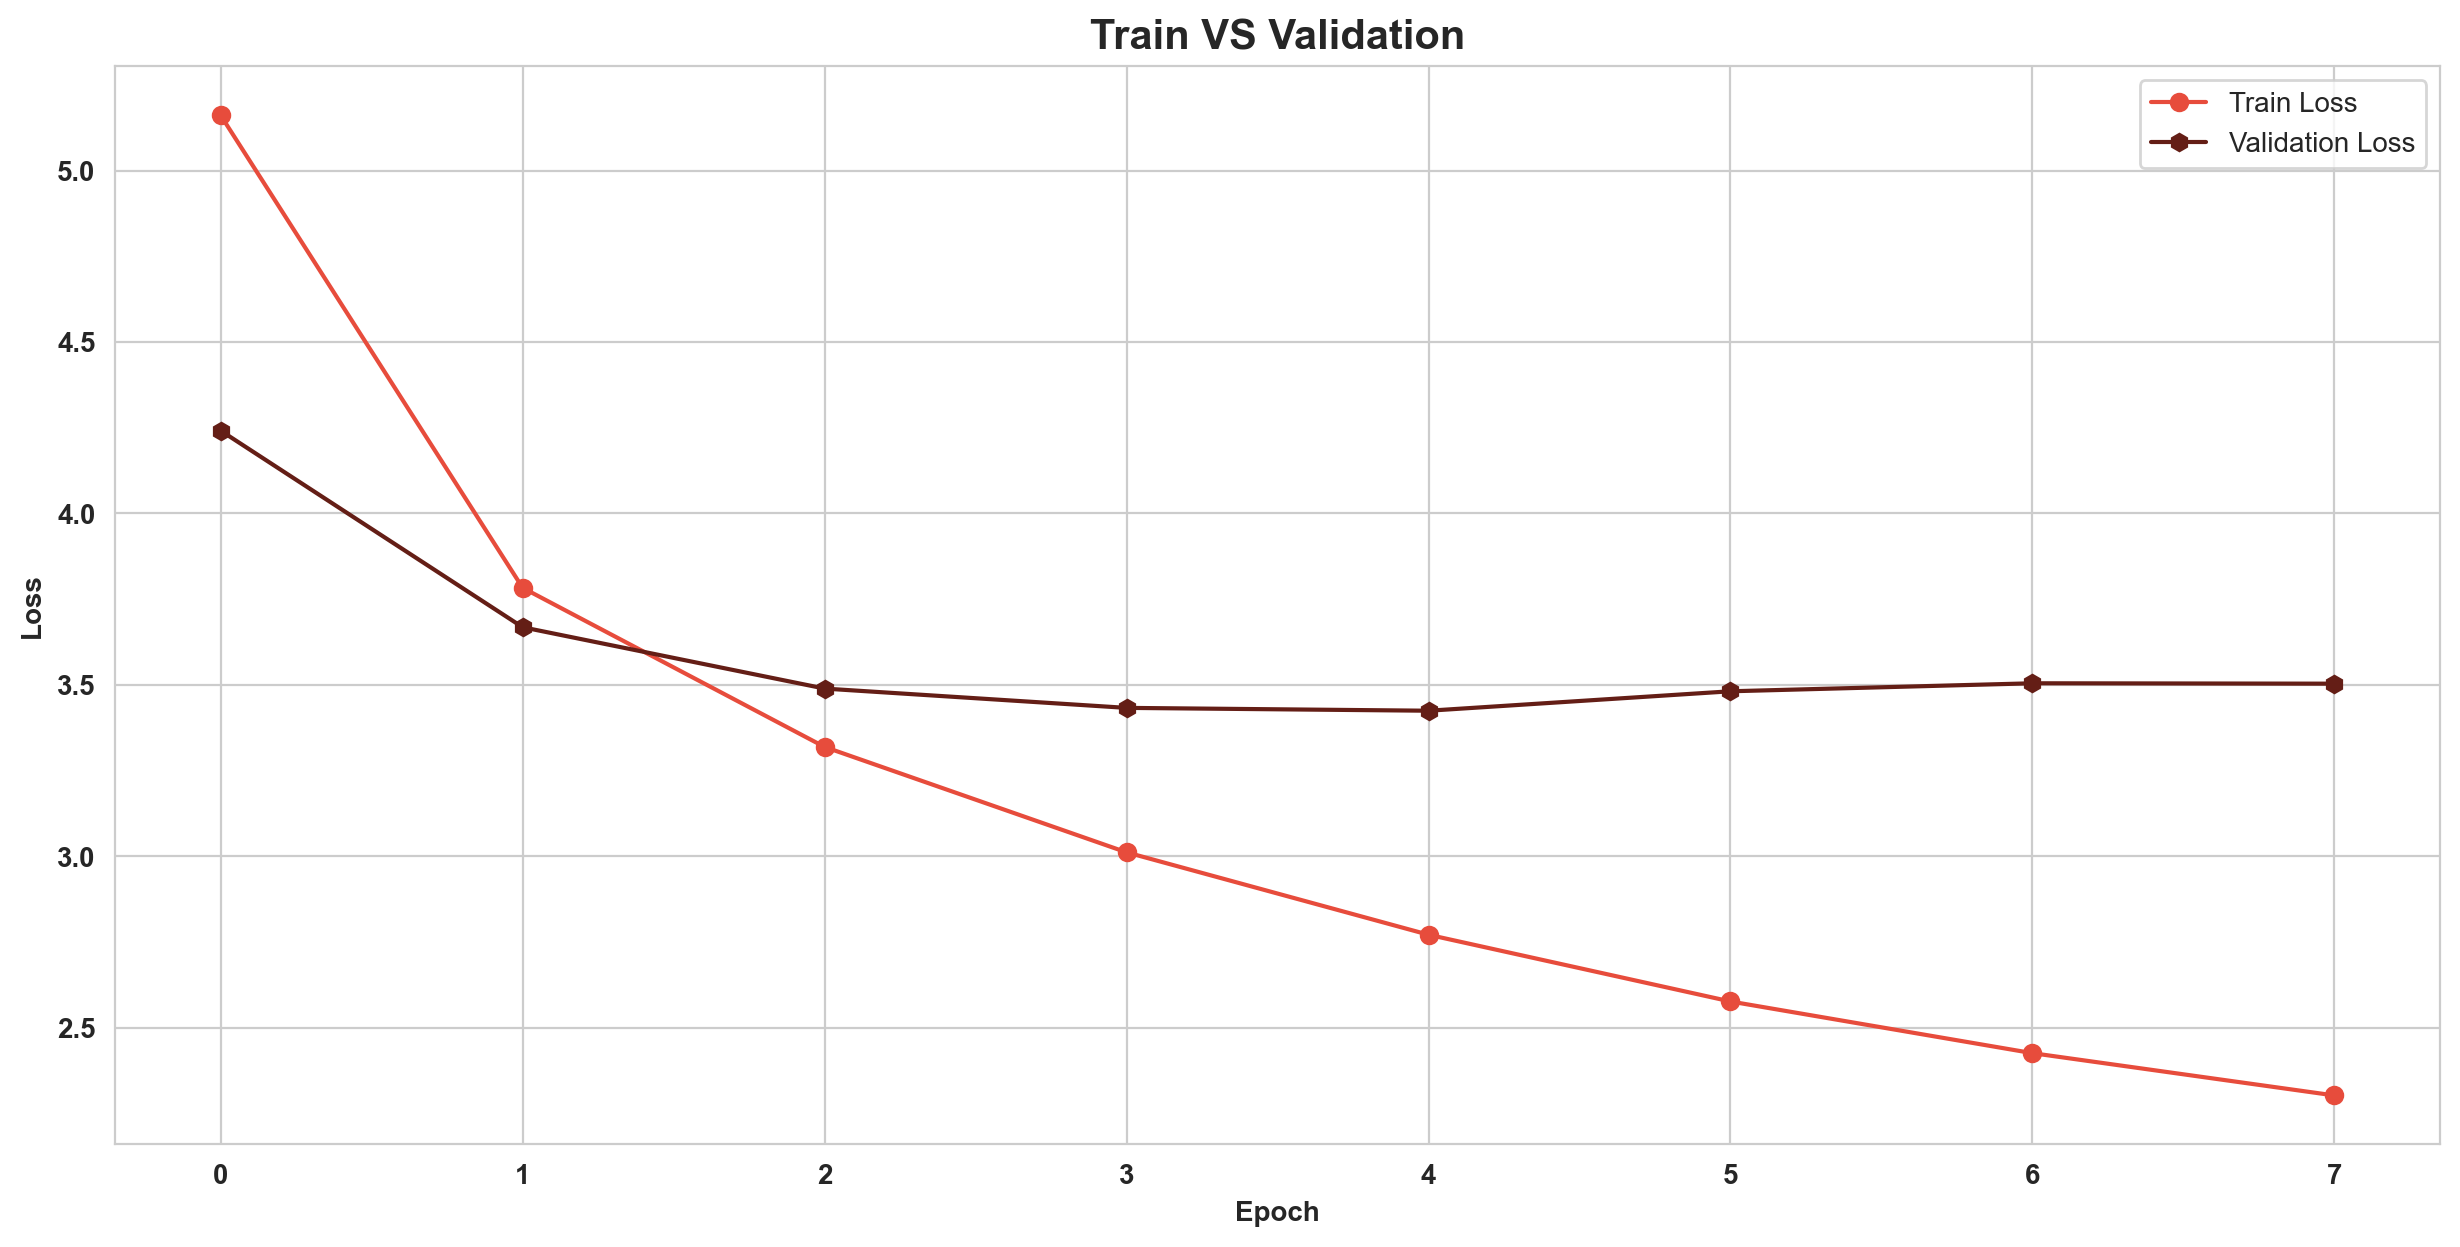

In [65]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

# L'evaluation du modele

In [14]:
def caption_generator(image_features,max_caption_length): # A function to generate captions
    # Each caption is started with the word 'start'
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer_instance.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1,max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1,output_dim_of_cnn_model), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer_instance.index_word[idx]
        # Adding the predicted word to the sequence
        in_text += ' ' + word
        # When the model returns the word 'end' (which is the end word), the generating loop must be stopped 
        if word == 'end':
            break
            
    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')
    
    return in_text

In [15]:
test_actual_captions = {}
for item in test_id_and_captions:
    image_id, caption = item.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption)

In [16]:
generated_captions = {}

for image_id in test_image_features:
    cap = caption_generator(test_image_features[image_id],caption_max_length)
    generated_captions[image_id] = cap

In [20]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def BLEU_score(actual, predicted):
    smoothing = SmoothingFunction().method4
    score_1 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0), smoothing_function=smoothing)
    score_2 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)

    return [
        (f'predicted: {predicted[0]}'),
        (f'score_1: {round(score_1, 5)}'),
        (f'score_2: {round(score_2, 5)}'),
    ]

In [ ]:
import sacrebleu

# Exemples de légendes réelles (actual captions)
actual_captions = ["a man is on a guitar"]

# Exemples de légendes générées par votre modèle (generated captions)
generated_captions = ["a man is playing guitar"]

# Fonction BLEU_score utilisant sacrebleu
def BLEU_score(actual, generated):
    # Calcul des scores BLEU
    bleu = sacrebleu.corpus_bleu(generated, [actual])
    
    return [
        f'BLEU score: {round(bleu.score, 5)}',
        f'actual: {actual[0]}\n'
        f'generated: {generated[0]}'
    ]

# Test de la fonction
results = BLEU_score(actual_captions, generated_captions)
for result in results:
    print(result)


BLEU score: 34.9833
actual: a man is on a guitar
generated: a man is playing guitar
